<a href="https://colab.research.google.com/github/KrishnanandSingh/EVA/blob/master/Assignment14EVA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow

TensorFlow 2.x selected.


In [2]:
print(tf.__version__)

2.0.0


In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tensorflow.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
import tensorflow as tf
HEIGHT = 40
WIDTH = 40
DEPTH = 3

def int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _floats_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def write_as_tfrecords(data, labels, output_file):
    with tf.io.TFRecordWriter(output_file) as record_writer:
        num_entries_in_batch = len(labels)
        for i in range(num_entries_in_batch):
            example = tf.train.Example(features=tf.train.Features(
                feature={
                    'image': _floats_feature(data[i].flatten()),
                    'label': int64_feature(labels[i])
                }))
            record_writer.write(example.SerializeToString())

def parse_fn(serialized_example):
    features = tf.io.parse_single_example(
        serialized_example,
        features={
            'image': tf.io.FixedLenFeature([WIDTH, HEIGHT, DEPTH], tf.float32),
            'label': tf.io.FixedLenFeature([], tf.int64),
        })
    image = features['image']
    label = features['label']
    return image, label

def load_tfr_dataset(tfrecordpath, FLAGS):
    files = tf.data.Dataset.list_files(tfrecordpath)
    dataset = files.interleave(
        tf.data.TFRecordDataset, cycle_length=tf.data.experimental.AUTOTUNE,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(
        buffer_size=FLAGS['shuffle_buffer_size'])
    dataset = dataset.map(map_func=parse_fn,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size=FLAGS['batch_size']).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


In [0]:
# write normalized data to tfrecord
write_as_tfrecords(x_train, y_train, 'train_data.tfrecord')

In [0]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, 4, 12, 14, 16, EPOCHS], [0.01, LEARNING_RATE, 0.03, 0.015, 0.01, 0.003])[0]
global_step = tf.compat.v1.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.compat.v1.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)

In [0]:
# loading the dataset
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.image.random_crop(x, [32, 32, 3])), y)
tf_set = load_tfr_dataset('train_data.tfrecord', {'shuffle_buffer_size': len_train, 'batch_size': BATCH_SIZE})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


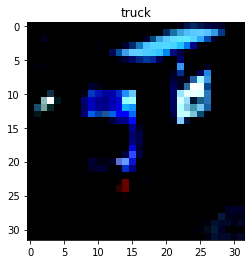

In [13]:
# displaying an example
for x,y in tf_set: break

%matplotlib inline 
def show_cifar_image(data_arr, label_arr, idx):
  from matplotlib import pyplot as plt
  cifar_objects = {0 : 'airplane',1 : 'automobile',2 : 'bird',3 : 'cat',4 : 'deer',5 : 'dog',6 : 'frog',7 : 'horse',8 : 'ship',9 : 'truck'}
  plt.imshow(data_arr[idx], interpolation='nearest')
  plt.title(cifar_objects[label_arr[idx]])
  plt.show()

show_cifar_image(x.numpy(), y.numpy(), 3)

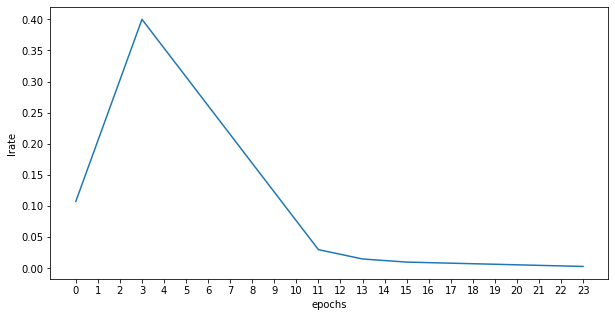

In [14]:
# plotting lr
%matplotlib inline
import matplotlib.pyplot as plt

def plot_line_graph(ax, y_arr, x_label, y_label, xmin=0, xmax=0, tick=1):
    ax.plot(y_arr)
    ax.set_xlabel(x_label)
    if xmax == 0:
      xmax = len(y_arr)
    xticks = [i for i in range(xmin, xmax)]
    ax.xaxis.set_ticks(xticks)
    ax.set_ylabel(y_label)


lrs = [lr_schedule(i) for i in range(1, EPOCHS+1)]
fig, axs = plt.subplots(1,1,figsize=(10,5))
plot_line_graph(axs, lrs, 'epochs', 'lrate')

In [15]:
t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# workaround for tqdm(iterator, total_count)
is_repeat = False

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0

  tf.keras.backend.set_learning_phase(1)
  if is_repeat:
    batch_no = 0
  for (x, y) in tqdm(tf_set):
    if is_repeat:
      if batch_no >= batches_per_epoch:
        break
      batch_no = batch_no + 1
    
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
  
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


epoch: 1 lr: 0.1075 train loss: 1.4750472131347656 train acc: 0.46834 val loss: 0.9689171905517578 val acc: 0.6498 time: 80.54556274414062



epoch: 2 lr: 0.20500000000000002 train loss: 0.819659108581543 train acc: 0.71004 val loss: 1.0879731719970702 val acc: 0.6369 time: 147.66593074798584



epoch: 3 lr: 0.3025 train loss: 0.6353351272583008 train acc: 0.78094 val loss: 0.7205989868164062 val acc: 0.7646 time: 214.74086594581604



epoch: 4 lr: 0.4 train loss: 0.5429921005249023 train acc: 0.81666 val loss: 0.779270458984375 val acc: 0.7701 time: 281.7717969417572



epoch: 5 lr: 0.35375 train loss: 0.42565806854248045 train acc: 0.85238 val loss: 0.526066471862793 val acc: 0.8221 time: 348.6835837364197



epoch: 6 lr: 0.3075 train loss: 0.3351160397338867 train acc: 0.8847 val loss: 0.4468662857055664 val acc: 0.8515 time: 415.6872298717499



epoch: 7 lr: 0.26125000000000004 train loss: 0.27492421798706057 train acc: 0.90342 val loss: 0.4298727600097656 val acc: 0.8574 time: 483.08873081207275



epoch: 8 lr: 0.21500000000000002 train loss: 0.23131830856323243 train acc: 0.91926 val loss: 0.32688998489379884 val acc: 0.8921 time: 550.5227086544037



epoch: 9 lr: 0.16875 train loss: 0.19371143280029296 train acc: 0.93276 val loss: 0.3017817611694336 val acc: 0.8988 time: 618.2940821647644



epoch: 10 lr: 0.12250000000000005 train loss: 0.16246622314453124 train acc: 0.94392 val loss: 0.3136076271057129 val acc: 0.8979 time: 685.2805500030518



epoch: 11 lr: 0.07625000000000004 train loss: 0.1319265828704834 train acc: 0.95542 val loss: 0.27502051162719726 val acc: 0.9112 time: 752.7873239517212



epoch: 12 lr: 0.03 train loss: 0.1057742202758789 train acc: 0.96608 val loss: 0.2542509811401367 val acc: 0.9179 time: 820.2690479755402



epoch: 13 lr: 0.0225 train loss: 0.09137310794830322 train acc: 0.97188 val loss: 0.24719919891357423 val acc: 0.9181 time: 887.527063369751



epoch: 14 lr: 0.015 train loss: 0.0837073413848877 train acc: 0.97438 val loss: 0.2457701156616211 val acc: 0.9202 time: 954.644547700882



epoch: 15 lr: 0.0125 train loss: 0.0811271868133545 train acc: 0.97492 val loss: 0.24438346557617188 val acc: 0.9211 time: 1021.619377374649



epoch: 16 lr: 0.01 train loss: 0.0776184769821167 train acc: 0.97654 val loss: 0.2419713665008545 val acc: 0.921 time: 1088.8077590465546



epoch: 17 lr: 0.009125 train loss: 0.07486533954620361 train acc: 0.97732 val loss: 0.24081533279418946 val acc: 0.9215 time: 1156.2276496887207



epoch: 18 lr: 0.00825 train loss: 0.07324831275939941 train acc: 0.9778 val loss: 0.24272095413208009 val acc: 0.9216 time: 1223.5487048625946



epoch: 19 lr: 0.007375 train loss: 0.07118955448150635 train acc: 0.9782 val loss: 0.2422952880859375 val acc: 0.9218 time: 1290.7263579368591



epoch: 20 lr: 0.006500000000000001 train loss: 0.07027054550170898 train acc: 0.97916 val loss: 0.2434404224395752 val acc: 0.9213 time: 1357.8874628543854



epoch: 21 lr: 0.005625 train loss: 0.06868602012634277 train acc: 0.9793 val loss: 0.24303346443176269 val acc: 0.9227 time: 1425.1876728534698



epoch: 22 lr: 0.00475 train loss: 0.06879182075500488 train acc: 0.97928 val loss: 0.2442364673614502 val acc: 0.9224 time: 1492.4473977088928



epoch: 23 lr: 0.003875 train loss: 0.0666741516494751 train acc: 0.98112 val loss: 0.24416481781005858 val acc: 0.9227 time: 1559.8551828861237



epoch: 24 lr: 0.003 train loss: 0.06635898685455323 train acc: 0.98076 val loss: 0.2443376419067383 val acc: 0.9225 time: 1627.1955687999725
